In [2]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline 
%precision 5

'%.5f'

## Discretization of kinematics 

We will use the Q4 element developed in the previous notebook. The goal here is to load again the ring mesh, deform it according to a given motion, and compute the deformation gradient at the center of the element using the finite element interpolation and compare against the analytical deformation gradient. 

Consider the following motion in 2D 

$$
\mathbf{\varphi}(\mathbf{X}) = \mathbf{x} = (\mathbf{X}\cdot\mathbf{X}) \mathbf{X}
$$ 

The analytical computation of the deformation gradient yields 

$$
\mathbf{F} = \frac{\partial  (\mathbf{X}\cdot\mathbf{X}) \mathbf{X}}{\partial \mathbf{X}} = \mathbf{X} \otimes \frac{\partial (\mathbf{X}\cdot \mathbf{X})}{\partial \mathbf{X}} + (\mathbf{X}\cdot \mathbf{X})\mathbf{I} = 2\mathbf{X}\otimes\mathbf{X} + (\mathbf{X}\cdot \mathbf{X})\mathbf{I} 
$$

In contrast, when we apply the motion to the nodes of the mesh we will obtained the deformed nodal positions $\mathbf{x}_i$. Then, for a given quadrilateral we need to also compute 

$$
\mathbf{F} = \frac{\partial \mathbf{x}}{\partial \mathbf{X}}
$$

But now the deformed position will actually be interpolated from the nodal values using the isoparametric map

$$
\mathbf{x} = \sum_i^{\#nodes} N_i^e(\mathbf{\xi}) \mathbf{x}_i^e
$$

Thus, the deformation gradient from the finite element interpolation requires the gradients $\nabla_X N_i^e$ with respect to the undeformed coordinates $\mathbf{X}$. To calculate those gradients we need to also recall the isoparametric map for the undeformed configuration 

$$
\mathbf{X} = \sum_i^{\#nodes} N_i^e(\mathbf{\xi}) \mathbf{X}_i^e
$$

With Jacobian 

$$\mathbf{J}_X = \nabla_\xi \mathbf{X} = \sum_i \mathbf{X}_i^e \otimes \nabla_\xi N_i(\mathbf{\xi})$$

We can use this Jacobian to compute derivatives with respect to $\mathbf{X}$ in the following way 

$$\nabla_X N_i = \mathbf{J}_X^{-T} \nabla_\xi N_i$$

And using the gradients $\nabla_X N_i$ we can finally get the deformation gradient 

$$
\mathbf{F} = \sum_i^{\#nodes} \mathbf{x}_i^e \otimes \nabla_X N_i
$$

In [3]:
# Definition of the shape function and the derivative with respect to parent domain xi

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

In [4]:
# read in a mesh 
## Read in a mesh 
meshfile = open("files/ring_mesh_ordered.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,4),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])
    elements[i,3] = int(aux[3])
#print(node_X)
#print(elements)
print(n_node)
print(n_elem)

576
512


In [5]:
# The motion! and the analytical deformaiton gradient 
def eval_phi(X):
    return np.dot(X,X)*X

def evalF(X):
    return 2*np.outer(X,X) + np.dot(X,X)*np.eye(2)

In [6]:
# deform the mesh according to th emotion and store the deformed nodal positions
node_x = np.zeros((n_node,2))
for i in range(n_node):
    node_x[i] = eval_phi(node_X[i])

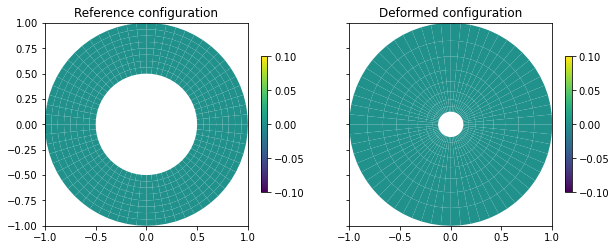

In [7]:
# plot 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,5))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_aspect('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_aspect('equal')
patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = 0
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)

patches2 = []
colors2 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches2.append(polygon)
    colors2[i] = 0
p2 = PatchCollection(patches2)
p2.set_array(colors2)
ax2.add_collection(p2)
ax1.set_title('Reference configuration')
ax2.set_title('Deformed configuration')
plt.colorbar(p1,ax=ax1,shrink=0.5)
plt.colorbar(p2,ax=ax2,shrink=0.5)

In [9]:
# use finite element discretization to interpolate the deformation gradient and compare against the
# analytical deformation gradient 

F_elem_analytical = np.zeros((n_elem,2,2))
F_elem_interpolated = np.zeros((n_elem,2,2))


for i in range(n_elem):
    
    # read out the nodes that make up this element 
    node1 = elements[i,0]
    node2 = elements[i,1]
    node3 = elements[i,2]
    node4 = elements[i,3]
    # Get the coordinates of the quad in the reference
    X1 = node_X[node1] 
    X2 = node_X[node2]
    X3 = node_X[node3]
    X4 = node_X[node4]
    # Get the deformed coordinates
    x1 = node_x[node1] 
    x2 = node_x[node2]
    x3 = node_x[node3]
    x4 = node_x[node4]
    
    # picking a point in parent domain, let's do the center!  
    xi = 0.0 
    eta = 0.0
    
    # evaluate the isoparametric map 
    Ns = Nvec(xi,eta)
    # reference 
    X = Ns[0]*X1 + Ns[1]*X2 + Ns[2]*X3 + Ns[3]*X4 
    # deformed 
    x = Ns[0]*x1 + Ns[1]*x2 + Ns[2]*x3 + Ns[3]*x4 
    
    # evaluate the Jacobian for X 
    dNsdxi = dNvecdxi(xi,eta)
    dXdxi = np.outer(X1,dNsdxi[:,0])+np.outer(X2,dNsdxi[:,1])+np.outer(X3,dNsdxi[:,2])+np.outer(X4,dNsdxi[:,3])
    # evaluate the Jacobian for x, I dont actually need it but let's do it 
    dxdxi = np.outer(x1,dNsdxi[:,0])+np.outer(x2,dNsdxi[:,1])+np.outer(x3,dNsdxi[:,2])+np.outer(x4,dNsdxi[:,3])
    
    # get gradient of basis function with respect to X and x using inverse jacobians 
    JXinvT = np.linalg.inv(dXdxi).transpose()
    dNsdX = np.dot(JXinvT,dNsdxi)
    JxinvT = np.linalg.inv(dxdxi).transpose()
    dNsdx = np.dot(JxinvT,dNsdxi)
    
    # now we can actually evaluate the interpolated deformation gradient 
    F_FE = np.outer(x1,dNsdX[:,0]) + np.outer(x2,dNsdX[:,1]) + np.outer(x3,dNsdX[:,2]) + np.outer(x4,dNsdX[:,3])
    F_elem_interpolated[i] = F_FE
    
    # the analytical one is just from eval the function 
    F_elem_analytical[i] = evalF(X)


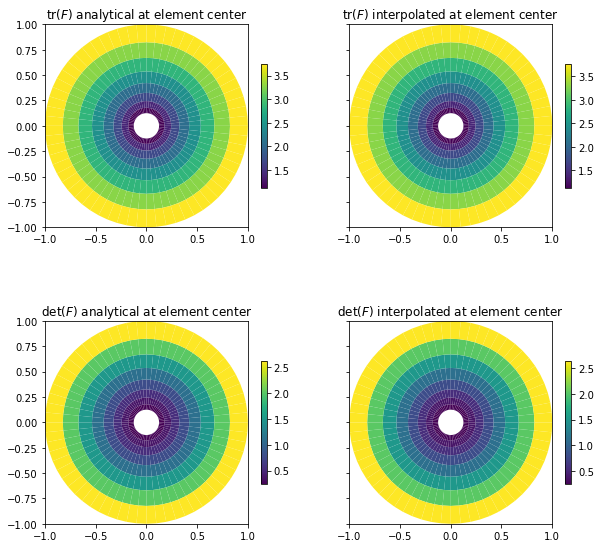

In [12]:
### PLOT the trace and determinant of F to compare, instead of individual components  

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(10,10))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_aspect('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_aspect('equal')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_aspect('equal')
ax4.set_xlim([-1, 1])
ax4.set_ylim([-1, 1])
ax4.set_aspect('equal')

patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = F_elem_analytical[i,0,0] + F_elem_analytical[i,1,1]
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)
ax1.set_title(r'$\mathrm{tr}(F)$ analytical at element center')

patches2 = []
colors2 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches2.append(polygon)
    colors2[i] = F_elem_interpolated[i,0,0] + F_elem_interpolated[i,1,1]
p2 = PatchCollection(patches2)
p2.set_array(colors2)
ax2.add_collection(p2)
ax2.set_title(r'$\mathrm{tr}(F)$ interpolated at element center')

patches3 = []
colors3 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches3.append(polygon)
    colors3[i] = F_elem_analytical[i,0,0]*F_elem_analytical[i,1,1] - F_elem_analytical[i,0,1]*F_elem_analytical[i,1,0]
p3 = PatchCollection(patches3)
p3.set_array(colors3)
ax3.add_collection(p3)
ax3.set_title(r'$\mathrm{det}(F)$ analytical at element center')

patches4 = []
colors4 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches4.append(polygon)
    colors4[i] = F_elem_interpolated[i,0,0]*F_elem_interpolated[i,1,1] - F_elem_interpolated[i,0,1]*F_elem_interpolated[i,1,0]
p4 = PatchCollection(patches4)
p4.set_array(colors4)
ax4.add_collection(p4)
ax4.set_title(r'$\mathrm{det}(F)$ interpolated at element center')

plt.colorbar(p1,ax=ax1,shrink=0.5)
plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p3,ax=ax3,shrink=0.5)
plt.colorbar(p4,ax=ax4,shrink=0.5)

Very good :) 

## Activity: gradients in reference and deformed configurations 

In some cases, we want to do computations in the deformed configuration. In particular, we want to get gradients with respect to $\mathbf{x}$ and gradients with respect to $\mathbf{X}$. 

Consider the scalar field in terms of the reference coordinates 

$$
\theta(\mathbf{X}) = \mathbf{X}\cdot\mathbf{X} 
$$ 

Do the following: 

* Evaluate $\theta$ at the nodes of the reference mesh and plot
* Assume that the field $\theta$ moves together with the nodes when we apply the deformation $\mathbf{\phi}$, plot the field over the deformed geometry 
* Using the isoparametric map of the reference configuration and the nodal values of $\theta$ compute the gradient $\nabla_X \theta$ 
* Using the isoparametric map of the deformed configuration and the same nodal values of $\theta$ compute the gradient 
$ \nabla_x \theta$ 
* Verify the identity $\nabla_x \theta = \mathbf{F}^{-T} \nabla_X \theta$

To plot the $\theta$ field, we need to find the interpolated value of $\theta$ at the center point of each element first. The value of $\theta$ at the center can be calculated from the nodal values by

$$
\theta^e (\boldsymbol{\xi}) = \sum\limits_{i=1}^{\#nodes} N_i(\boldsymbol{\xi}) \theta^e_i .
$$

The gradient $\nabla_\mathbf{X} \theta$ and $\nabla_\mathbf{x} \theta$ are calculated by

$$
\nabla_\mathbf{X} \theta^e = \sum\limits_{i=1}^{\#nodes} \theta^e_i \mathbf{J}^\top \nabla_\boldsymbol{\xi} N_i(\boldsymbol{\xi}) = \sum\limits_{i=1}^{\#nodes} \theta^e_i \nabla_\mathbf{X} N_i(\boldsymbol{\xi})
$$

and

$$
\nabla_\mathbf{x} \theta^e = \sum\limits_{i=1}^{\#nodes} \theta^e_i \mathbf{j}^\top \nabla_\boldsymbol{\xi} N_i(\boldsymbol{\xi}) = \sum\limits_{i=1}^{\#nodes} \theta^e_i \nabla_\mathbf{x} N_i(\boldsymbol{\xi}) .
$$

In [16]:
#Compute the value of theta at each node
theta_node = np.zeros((n_node))
for i in range(n_node):
    theta_node[i] = np.dot(node_X[i],node_X[i])

theta_elem_interpolated = np.zeros((n_elem))
theta_gradient_X = np.zeros((n_elem,2))
theta_gradient_x = np.zeros((n_elem,2))
F_elem_interpolated = np.zeros((n_elem,2,2))
#Copied from above and modified to compute the requested values at the center of each element
for i in range(n_elem):
    
    # read out the nodes that make up this element 
    node1 = elements[i,0]
    node2 = elements[i,1]
    node3 = elements[i,2]
    node4 = elements[i,3]
    # get the coordinates of the quad in the reference
    X1 = node_X[node1] 
    X2 = node_X[node2]
    X3 = node_X[node3]
    X4 = node_X[node4]
    # get the deformed coordinates
    x1 = node_x[node1] 
    x2 = node_x[node2]
    x3 = node_x[node3]
    x4 = node_x[node4]
    # get the nodal values of theta
    theta1 = theta_node[node1]
    theta2 = theta_node[node2]
    theta3 = theta_node[node3]
    theta4 = theta_node[node4]
    
    # picking a point in parent domain, let's do the center!  
    xi = 0.0 
    eta = 0.0
    
    # evaluate the isoparametric map 
    Ns = Nvec(xi,eta)
    # reference 
    X = Ns[0]*X1 + Ns[1]*X2 + Ns[2]*X3 + Ns[3]*X4 
    # deformed 
    x = Ns[0]*x1 + Ns[1]*x2 + Ns[2]*x3 + Ns[3]*x4 
    
    # evaluate the Jacobian for X 
    dNsdxi = dNvecdxi(xi,eta)
    dXdxi = np.outer(X1,dNsdxi[:,0])+np.outer(X2,dNsdxi[:,1])+np.outer(X3,dNsdxi[:,2])+np.outer(X4,dNsdxi[:,3])
    # evaluate the Jacobian for x
    dxdxi = np.outer(x1,dNsdxi[:,0])+np.outer(x2,dNsdxi[:,1])+np.outer(x3,dNsdxi[:,2])+np.outer(x4,dNsdxi[:,3])
    
    # get gradient of basis function with respect to X and x using inverse jacobians 
    JXinvT = np.linalg.inv(dXdxi).transpose()
    dNsdX = np.dot(JXinvT,dNsdxi)
    JxinvT = np.linalg.inv(dxdxi).transpose()
    dNsdx = np.dot(JxinvT,dNsdxi)
    
    # now we can actually evaluate the interpolated values
    theta_elem_interpolated[i] = Ns[0]*theta1 + Ns[1]*theta2 + Ns[2]*theta3 + Ns[3]*theta4
    
    theta_gradient_X[i] = theta1*dNsdX[:,0] + theta2*dNsdX[:,1] + theta3*dNsdX[:,2] + theta4*dNsdX[:,3]
    theta_gradient_x[i] = theta1*dNsdx[:,0] + theta2*dNsdx[:,1] + theta3*dNsdx[:,2] + theta4*dNsdx[:,3]
    F_elem_interpolated[i] = np.outer(x1,dNsdX[:,0]) + np.outer(x2,dNsdX[:,1]) + np.outer(x3,dNsdX[:,2]) + np.outer(x4,dNsdX[:,3])


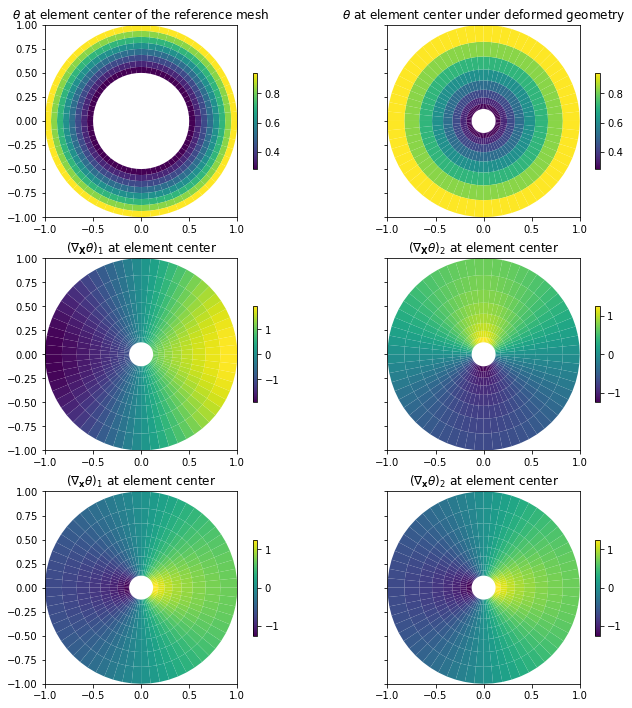

In [33]:
### PLOT the field theta and its gradient in the reference and deformed configuration

f, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, sharey=True,figsize=(10,10))
f.tight_layout(pad=2.0)
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_aspect('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_aspect('equal')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_aspect('equal')
ax4.set_xlim([-1, 1])
ax4.set_ylim([-1, 1])
ax4.set_aspect('equal')
ax5.set_xlim([-1, 1])
ax5.set_ylim([-1, 1])
ax5.set_aspect('equal')
ax6.set_xlim([-1, 1])
ax6.set_ylim([-1, 1])
ax6.set_aspect('equal')

#Subplot 1: the theta field in the reference mesh
patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = theta_elem_interpolated[i]
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)
ax1.set_title(r'$\theta$ at element center of the reference mesh')

#Subplot 2: the moved theta field on the deformed geometry
patches2 = []
colors2 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches2.append(polygon)
    colors2[i] = theta_elem_interpolated[i]
p2 = PatchCollection(patches2)
p2.set_array(colors2)
ax2.add_collection(p2)
ax2.set_title(r'$\theta$ at element center under deformed geometry')

#Subplot 3a: the first component of the gradient wrt the reference configuration
patches3 = []
colors3 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches3.append(polygon)
    colors3[i] = theta_gradient_X[i,0]
p3 = PatchCollection(patches3)
p3.set_array(colors3)
ax3.add_collection(p3)
ax3.set_title(r'$(\nabla_\mathbf{X} \theta)_1$ at element center')

#Subplot 3b: the seconde component of the gradient wrt the reference configuration
patches4 = []
colors4 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches4.append(polygon)
    colors4[i] = theta_gradient_x[i,1]
p4 = PatchCollection(patches4)
p4.set_array(colors4)
ax4.add_collection(p4)
ax4.set_title(r'$(\nabla_\mathbf{X} \theta)_2$ at element center')

#Subplot 4a: the first component of the gradient wrt the current configuration
patches5 = []
colors5 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches5.append(polygon)
    colors5[i] = theta_gradient_x[i,0]
p5 = PatchCollection(patches5)
p5.set_array(colors5)
ax5.add_collection(p5)
ax5.set_title(r'$(\nabla_\mathbf{x} \theta)_1$ at element center')

#Subplot 4b: the seconde component of the gradient wrt the current configuration
patches6 = []
colors6 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches6.append(polygon)
    colors6[i] = theta_gradient_x[i,0]
p6 = PatchCollection(patches6)
p6.set_array(colors6)
ax6.add_collection(p6)
ax6.set_title(r'$(\nabla_\mathbf{x} \theta)_2$ at element center')

plt.colorbar(p1,ax=ax1,shrink=0.5)
plt.colorbar(p2,ax=ax2,shrink=0.5)
plt.colorbar(p3,ax=ax3,shrink=0.5)
plt.colorbar(p4,ax=ax4,shrink=0.5)
plt.colorbar(p5,ax=ax5,shrink=0.5)
plt.colorbar(p6,ax=ax6,shrink=0.5)

Now we verify that

$$
\nabla_x \theta = \mathbf{F}^{-T} \nabla_X \theta .
$$

We do it numerically by adding the norms of the difference of the LHS and RHS of the above equation in all the elements. If the accumulated absolute sum were small enough, then the equation above holds all the time.

In [28]:
absSum = 0
for i in range(n_elem):
    LHS = theta_gradient_x[i]
    RHS = np.dot(np.linalg.inv(F_elem_interpolated[i]).transpose(),theta_gradient_X[i])
    absSum += np.linalg.norm(LHS - RHS)
print(absSum)

7.781008436684582e-13
